In [1]:
import multi_axis as ma
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from scipy import constants                     # For scientific constants
%config Completer.use_jedi = False

Astra import failed


In [125]:
def convertmag_T_Am(M_T):
    """ Enter 'equivalent' magnetisation in Tesla
    for a conversion to A/m.
    Can also input common materials as string, e.g. 
    'cobalt' """
    if M_T == 'cobalt':
        M_Am = 1435860
        
    else:
        M_Am = M_T / (4*np.pi*1e-7)
        
    return M_Am

class Magnetic_Phantom():
    """ Class for creating magnetic phantoms """

    def sphere(rad_m = 10*1e-9, Ms_Am = 797700, plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates uniformly magnetised sphere
            rad_m : Radius in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    if (i-ci)**2 + (j-ci)**2 + (k-ci)**2 < (rad_m/res)**2:
                        MX[i,j,k] = np.cos(plan_rot*np.pi/180)*Ms_Am
                        MY[i,j,k] = np.sin(plan_rot*np.pi/180)*Ms_Am
        
        return MX,MY,MZ, mesh_params
    
    def rectangle(lx_m = 80*1e-9,ly_m = 30*1e-9, lz_m = 20*1e-9, Ms_Am = 797700, 
                  plan_rot=0, p2 = (100*1e-9,100*1e-9,100*1e-9), n=(100,100,100)):
        """ Creates uniformly magnetised rectangle
            l_m = length of rectangle in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        # Initialise bounding box parameters
        p1 = (0,0,0)
        mesh_params = [p1,p2,n]
        resx = p2[0]/n[0] # resolution in m per px 
        resy = p2[1]/n[1] # resolution in m per px 
        resz = p2[2]/n[2] # resolution in m per px 
        cix = int(n[0]/2) # index of bbox centre
        ciy = int(n[1]/2) # index of bbox centre
        ciz = int(n[2]/2) # index of bbox centre

        # Initialise magnetisation arrays
        mx = np.linspace(0,p2[0],num=n[0]) * 0
        my = np.linspace(0,p2[1],num=n[1]) * 0
        mz = np.linspace(0,p2[2],num=n[2]) * 0
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    if cix-.5*lx_m/resx < i < cix+.5*lx_m/resx and \
                       ciy-.5*ly_m/resy < j < ciy+.5*ly_m/resy and \
                       ciz-.5*lz_m/resz < k < ciz+.5*lz_m/resz:
                        MX[i,j,k] = np.cos(plan_rot*np.pi/180)*Ms_Am
                        MY[i,j,k] = np.sin(plan_rot*np.pi/180)*Ms_Am

        return MX,MY,MZ, mesh_params
    
    def disc_vortex(rad_m = 30*1e-9, lz_m = 20*1e-9, Ms_Am = 797700, 
                  plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates disk with c/w vortex magnetisation
            rad_m : Radius in metres
            lz_m = thickness of disc in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        
        def vortex(x,y):
            """ Returns mx/my components for vortex state, 
            given input x and y """
            # angle between tangent and horizontal
            theta=-1*np.arctan2(x,y)
            # cosine/sine components
            C=np.cos(theta)
            S = np.sin(theta)
            return C, S
        
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    if (i-ci)**2 + (j-ci)**2 < (rad_m/res)**2 and ci-.5*lz_m/res < k < ci+.5*lz_m/res:
                        mx,my = vortex(i-ci,j-ci)
                        MX[i,j,k] = mx*Ms_Am
                        MY[i,j,k] = my*Ms_Am
                        
        
        return MX,MY,MZ, mesh_params
    
    def disc_uniform(rad_m = 30*1e-9, lz_m = 20*1e-9, Ms_Am = 797700, 
                  plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates disk with c/w vortex magnetisation
            rad_m : Radius in metres
            lz_m = thickness of disc in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    if (i-ci)**2 + (j-ci)**2 < (rad_m/res)**2 and ci-.5*lz_m/res < k < ci+.5*lz_m/res:
                        MX[i,j,k] = np.cos(plan_rot*np.pi/180)*Ms_Am
                        MY[i,j,k] = np.sin(plan_rot*np.pi/180)*Ms_Am
                        
        
        return MX,MY,MZ, mesh_params
    
    def tri_pris(rad_m = 30*1e-9, lz_m = 20*1e-9, Ms_Am = 797700, 
                  plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates disk with c/w vortex magnetisation
            rad_m : Radius in metres
            lz_m = thickness of disc in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')
        
        # Define gradient/intercept of bounding lines
        m1, c1 = 5, 100
        m2, c2 = 0, -25
        m3, c3 = -0.6, 0

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    x = i-ci
                    y = j-ci
                    z = k-ci
                    if y < (m1*x+c1) and y > (m2*x + c2) and y < (m3*x + c3) and ((z >-20 and z<-10) or (z>0 and z<30)):
                        MX[i,j,k] = Ms_Am
                        
        #MX = np.swapaxes(MX,0,1)
                        
        return MX,MY,MZ, mesh_params
    
    def rod(rad_m = 10*1e-9, lx_m = 60*1e-9, Ms_Am = 797700, 
                  plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates uniformly magnetised cylindrical rod lying along x
            rad_m : Radius in metres
            lx_m = length of rod in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    x = i-ci
                    y = j-ci
                    z = k-ci
                    if (k-ci)**2 + (j-ci)**2 < (rad_m/res)**2 and ci-.5*lx_m/res < i < ci+.5*lx_m/res:
                        MX[i,j,k] = Ms_Am
                        
        #MX = np.swapaxes(MX,0,1)
                        
        return MX,MY,MZ, mesh_params

def plot_2d_mag(mx,my,mesh_params=None,Ms=None,s=1):
    """ Takes x/y magnetisation projections and creates a plot
        uses quivers for direction and colour for magnitude """
    if type(Ms) == type(None):
        Ms = np.max(np.max((mx**2+my**2)**.5))
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()

    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x = np.linspace(p1[0],p2[0],num=n[0])
    y = np.linspace(p1[1],p2[1],num=n[1])
    xs,ys = np.meshgrid(x,y)
    
    plt.quiver(xs[::s,::s],ys[::s,::s],mx[::s,::s].T,my[::s,::s].T,pivot='mid',scale=Ms*22,width=0.009,headaxislength=5,headwidth=4,minshaft=1.8)
    mag = (mx**2+my**2)**.5
    plt.imshow(mag.T,origin='lower',extent=[p1[0],p2[0],p1[1],p2[1]],vmin=0,vmax=Ms,cmap='Blues')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('$|M_{\perp}$| / $A $', rotation=-270,fontsize=15)
    
    plt.xlabel('x / m',fontsize=15)
    plt.ylabel('y / m',fontsize=15)
    plt.show()
    
def project_along_z(U,mesh_params=None):
    """ Takes a 3D array and projects along the z component 
    It does this by multiplying each layer by its thickness
    and then summing down the axis. """
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(U)
        p2 = (sx,sy,sz)
        n = p2
    else:
        p1,p2,n = mesh_params
    
    # Get resolution    
    z_size = p2[2]
    z_res = z_size/n[2]
    
    # project
    u_proj = np.sum(U*z_res,axis=2)
    
    return u_proj

def calculate_A_3D(MX,MY,MZ, mesh_params=None,n_pad=100,tik_filter=0.01):
    """ Input(3D (nx,ny,nz) array for each component of M) and return
    three 3D arrays of magnetic vector potential 
    
    Note, returned arrays will remain padded since if they are used for
    projection to phase change this will make a difference. So the new
    mesh parameters are also returned
    
    """
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(MX)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
    
    # zero pad M to avoid FT convolution wrap-around artefacts
    mxpad = np.pad(MX,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mypad = np.pad(MY,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mzpad = np.pad(MZ,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)

    # take 3D FT of M    
    ft_mx = np.fft.fftn(mxpad)
    ft_my = np.fft.fftn(mypad)
    ft_mz = np.fft.fftn(mzpad)
    
    # Generate K values
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 

    kx = np.fft.fftfreq(ft_mx.shape[0],d=resx)
    ky = np.fft.fftfreq(ft_my.shape[0],d=resy)
    kz = np.fft.fftfreq(ft_mz.shape[0],d=resz)
    KX, KY, KZ = np.meshgrid(kx,ky,kz, indexing='ij') # Create a grid of coordinates
    
    # vacuum permeability
    mu0 = 4*np.pi*1e-7
    
    # Calculate 1/k^2 with Tikhanov filter
    if tik_filter == 0:
        K2_inv = np.nan_to_num(((KX**2+KY**2+KZ**2)**.5)**-2)
    else:
        K2_inv = ((KX**2+KY**2+KZ**2)**.5 + tik_filter*resx)**-2
    
    # M cross K
    cross_x = ft_my*KZ - ft_mz*KY
    cross_y = -ft_mx*KZ + ft_mz*KX
    cross_z = -ft_my*KX + ft_mx*KY
    
    # Calculate A(k)
    ft_Ax = (-1j * mu0 * K2_inv) * cross_x
    ft_Ay = (-1j * mu0 * K2_inv) * cross_y
    ft_Az = (-1j * mu0 * K2_inv) * cross_z
    
    # Inverse fourier transform
    Ax = np.fft.ifftn(ft_Ax)
    AX = Ax.real
    Ay = np.fft.ifftn(ft_Ay)
    AY = Ay.real
    Az = np.fft.ifftn(ft_Az)
    AZ = Az.real
    
    # new mesh parameters (with padding)
    n = (n[0]+2*n_pad,n[1]+2*n_pad,n[2]+2*n_pad)
    p2 = (p2[0]+2*n_pad*resx,p2[1]+2*n_pad*resy,p2[2]+2*n_pad*resz)
    mesh_params=(p1,p2,n)
    
    return AX,AY,AZ,mesh_params

def calculate_phase_AZ(AZ,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(MX)
        p2 = (sx,sy,sx)
        n = p2
        mesh_params = [p1,p2,n]
    else:
        p1,p2,n = mesh_params
    """ Calculates projected phase change from 3D AZ """
    AZ_proj = project_along_z(AZ,mesh_params=mesh_params) 
    phase = AZ_proj * -1* np.pi/constants.codata.value('mag. flux quantum') / (2*np.pi)
    return phase

def calculate_phase_M_2D(MX,MY,MZ,mesh_params,n_pad=500,tik_filter=0.01):
    """ Preffered method. Takes 3D MX,MY,MZ magnetisation arrays
    and calculates phase shift in rads in z direction.
    First projects M from 3D to 2D which speeds up calculations """
    p1,p2,n=mesh_params
    
    # J. Loudon et al, magnetic imaging, eq. 29
    const = .5 * 1j * 4*np.pi*1e-7 / constants.codata.value('mag. flux quantum')

    # Define resolution from mesh parameters
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 
    
    # Project magnetisation array
    mx = project_along_z(MX,mesh_params=mesh_params)
    my = project_along_z(MY,mesh_params=mesh_params)
    
    # Take fourier transform of M
    # Padding necessary to stop Fourier convolution wraparound (spectral leakage)
    if n_pad > 0:
        mx = np.pad(mx,[(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
        my = np.pad(my,[(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    
    ft_mx = np.fft.fft2(mx)
    ft_my = np.fft.fft2(my)
    
    # Generate K values
    kx = np.fft.fftfreq(n[0]+2*n_pad,d=resx)
    ky = np.fft.fftfreq(n[1]+2*n_pad,d=resy)
    KX, KY = np.meshgrid(kx,ky, indexing='ij') # Create a grid of coordinates
    
    # Filter to avoid division by 0
    if tik_filter == 0:
        K2_inv = np.nan_to_num(((KX**2+KY**2)**.5)**-2)
    else:
        K2_inv = ((KX**2+KY**2)**.5 + tik_filter*resx)**-2

    # Take cross product (we only need z component)
    cross_z = (-ft_my*KX + ft_mx*KY)*K2_inv
    
    # Inverse fourier transform
    phase = np.fft.ifft2(const*cross_z).real
    
    # Unpad
    if n_pad > 0:
        phase=phase[n_pad:-n_pad,n_pad:-n_pad]
    
    return phase

def calculate_phase_M_3D(MX,MY,MZ,mesh_params,n_pad=100,tik_filter=0.01):
    """ Slower than 2D but good for comparison. Takes 3D MX,MY,MZ magnetisation arrays
    and calculates phase shift in rads in z direction.
    Calculations performed directly in 3D """
    p1,p2,n=mesh_params
    
    # constant prefactor
    const = .5*1j*4*np.pi*1e-7/constants.codata.value('mag. flux quantum')

    # Generate K values
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 
    MX = np.pad(MX,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    MY = np.pad(MY,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    MZ = np.pad(MZ, [(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    kx = np.fft.fftfreq(n[0]+2*n_pad,d=resx)
    ky = np.fft.fftfreq(n[1]+2*n_pad,d=resy)
    kz = np.fft.fftfreq(n[2]+2*n_pad,d=resz)
    KX, KY, KZ = np.meshgrid(kx,ky,kz, indexing='ij') # Create a grid of coordinates
    K2_inv = np.nan_to_num(((KX**2+KY**2+KZ**2)**.5+ tik_filter*resx)**-2)
    
    # Take 3D fourier transforms (only need x and y for cross-z)
    ft_mx = np.fft.fftn(MX)
    ft_my = np.fft.fftn(MY)
    
    # take cross product
    cross_z = (-ft_my*KX + ft_mx*KY) * K2_inv
    
    # extract central slice
    slice_z = cross_z[:,:,0] * resz 
    
    # inverse fourier transform
    phase = np.fft.ifft2(const*slice_z).real
    
    if n_pad > 0:
        phase = phase[n_pad:-n_pad,n_pad:-n_pad]
    
    return phase

def analytical_sphere(B0_T=1.6,r_m=50*1e-9,mesh_params=None,beta=-90,n_pad=100):
    """ Analytically calculates the phase change for a sphere (from Beleggia and Zhu 2003)"""
    import scipy
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    p1,p2,n=mesh_params
    
    # Calculate prefactor
    const = 4 * np.pi**2 * 1j * B0_T  *(r_m/2/np.pi)**2/ constants.codata.value('mag. flux quantum')
    
    # Generate K values
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    
    kx = np.fft.fftfreq(n[0]+2*n_pad,d=resx)#/(2*np.pi))
    ky = np.fft.fftfreq(n[1]+2*n_pad,d=resy)#/(2*np.pi))
    KX, KY = np.meshgrid(kx,ky)#,indexing='ij') # Create a grid of coordinates
    
    # Calculate 1/k^2 with Tikhanov filter
    K3_inv = np.nan_to_num(((KX**2+KY**2)**.5)**-3)
    K =(KX**2+KY**2)**.5

    #The normalized sinc function is the Fourier transform of the rectangular function with no scaling. np default is normalised
    phase_ft = const * (KY*np.cos(beta*np.pi/180) - KX*np.sin(beta*np.pi/180)) * K3_inv \
                        * scipy.special.spherical_jn(1,r_m*(2*np.pi)*K) / (resx*resy)
    
    phase = np.fft.ifft2(phase_ft).real 
    
    phase = np.fft.ifftshift(phase) 
    
    phase = phase[n_pad:-n_pad,n_pad:-n_pad]
    
    return phase

def analytical_rectangle(B0_T=1.6,lx_m=200*1e-9,ly_m=140*1e-9,lz_m=20*1e-9,mesh_params=None,beta=300,n_pad=100):
    """ Analytically calculates the phase change for a rectangle (from Beleggia and Zhu 2003)"""
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    p1,p2,n=mesh_params
    
    # Calculate prefactor
    V = lx_m*ly_m*lz_m
    const = 1j*np.pi*B0_T*V/constants.codata.value('mag. flux quantum')
    
    # Generate K values
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 

    kx = np.fft.fftfreq(n[0]+2*n_pad,d=resx)
    ky = np.fft.fftfreq(n[1]+2*n_pad,d=resy)
    KX, KY = np.meshgrid(kx,ky,indexing='ij') # Create a grid of coordinates
    #KX,KY=KX*(2*np.pi),KY*(2*np.pi)
    
    # Calculate 1/k^2 with Tikhanov filter
    K2_inv = np.nan_to_num(((KX**2+KY**2)**.5)**-2)

    #The normalized sinc function is the Fourier transform of the rectangular function with no scaling. np default is normalised
    phase_ft = const * K2_inv * (KY*np.cos(beta*np.pi/180) - KX*np.sin(beta*np.pi/180)) * np.sinc(lx_m*KX) * np.sinc(ly_m*KY) / (resx*resy)
    
    phase = np.fft.ifft2(phase_ft).real
    
    phase = np.fft.ifftshift(phase) / (2*np.pi)
    
    if n_pad>0:
        phase = phase[n_pad:-n_pad,n_pad:-n_pad]
    
    return phase

def linsupPhi(mx=1.0, my=1.0, mz=1.0, Dshp=None, theta_x=0.0, theta_y=0.0, pre_B=1.0, pre_E=1, v=1, multiproc=True):
    """Applies linear superposition principle for 3D reconstruction of magnetic and electrostatic phase shifts.
    This function will take 3D arrays with Mx, My and Mz components of the 
    magnetization, the Dshp array consisting of the shape function for the 
    object (1 inside, 0 outside), and the tilt angles about x and y axes to 
    compute the magnetic and the electrostatic phase shift. Initial computation 
    is done in Fourier space and then real space values are returned.
    Args: 
        mx (3D array): x component of magnetization at each voxel (z,y,x)
        my (3D array): y component of magnetization at each voxel (z,y,x)
        mz (3D array): z component of magnetization at each voxel (z,y,x)
        Dshp (3D array): Binary shape function of the object. Where value is 0,
            phase is not computed.  
        theta_x (float): Rotation around x-axis (degrees). Rotates around x axis
            then y axis if both are nonzero. 
        theta_y (float): Rotation around y-axis (degrees) 
        pre_B (float): Numerical prefactor for unit conversion in calculating 
            the magnetic phase shift. Units 1/pixels^2. Generally 
            (2*pi*b0*(nm/pix)^2)/phi0 , where b0 is the Saturation induction and 
            phi0 the magnetic flux quantum. 
        pre_E (float): Numerical prefactor for unit conversion in calculating the 
            electrostatic phase shift. Equal to sigma*V0, where sigma is the 
            interaction constant of the given TEM accelerating voltage (an 
            attribute of the microscope class), and V0 the mean inner potential.
        v (int): Verbosity. v >= 1 will print status and progress when running
            without numba. v=0 will suppress all prints. 
        mp (bool): Whether or not to implement multiprocessing. 
    Returns: 
        tuple: Tuple of length 2: (ephi, mphi). Where ephi and mphi are 2D numpy
        arrays of the electrostatic and magnetic phase shifts respectively. 
    """
    import time
    vprint = print if v>=1 else lambda *a, **k: None
    [dimz,dimy,dimx] = mx.shape
    dx2 = dimx//2
    dy2 = dimy//2
    dz2 = dimz//2

    ly = (np.arange(dimy)-dy2)/dimy
    lx = (np.arange(dimx)-dx2)/dimx
    [Y,X] = np.meshgrid(ly,lx, indexing='ij')
    dk = 2.0*np.pi # Kspace vector spacing
    KX = X*dk
    KY = Y*dk
    KK = np.sqrt(KX**2 + KY**2) # same as dist(ny, nx, shift=True)*2*np.pi
    zeros = np.where(KK == 0)   # but we need KX and KY later. 
    KK[zeros] = 1.0 # remove points where KK is zero as will divide by it

    # compute S arrays (will apply constants at very end)
    inv_KK =  1/KK**2
    Sx = 1j * KX * inv_KK
    Sy = 1j * KY * inv_KK
    Sx[zeros] = 0.0
    Sy[zeros] = 0.0
    
    # Get indices for which to calculate phase shift. Skip all pixels where
    # thickness == 0 
    if Dshp is None: 
        Dshp = np.ones(mx.shape)
    # exclude indices where thickness is 0, compile into list of ((z1,y1,x1), (z2,y2...
    zz, yy, xx = np.where(Dshp != 0)
    inds = np.dstack((zz,yy,xx)).squeeze()

    # Compute the rotation angles
    st = np.sin(np.deg2rad(theta_x))
    ct = np.cos(np.deg2rad(theta_x))
    sg = np.sin(np.deg2rad(theta_y))
    cg = np.cos(np.deg2rad(theta_y))

    x = np.arange(dimx) - dx2
    y = np.arange(dimy) - dy2
    z = np.arange(dimz) - dz2
    Z,Y,X = np.meshgrid(z,y,x, indexing='ij') # grid of actual positions (centered on 0)

    # compute the rotated values; 
    # here we apply rotation about X first, then about Y
    i_n = Z*sg*ct + Y*sg*st + X*cg
    j_n = Y*ct - Z*st

    mx_n = mx*cg + my*sg*st + mz*sg*ct
    my_n = my*ct - mz*st

    # setup 
    mphi_k = np.zeros(KK.shape,dtype=complex)
    ephi_k = np.zeros(KK.shape,dtype=complex)

    nelems = np.shape(inds)[0]
    stime = time.time()
    vprint(f'Beginning phase calculation for {nelems:g} voxels.')
    if multiproc:
        vprint("Running in parallel with numba.")
        ephi_k, mphi_k = exp_sum(mphi_k, ephi_k, inds, KY, KX, j_n, i_n, my_n, mx_n, Sy, Sx)        

    else:
        vprint("Running on 1 cpu.")
        otime = time.time()
        vprint('0.00%', end=' .. ')
        cc = -1
        for ind in inds:
            ind = tuple(ind)
            cc += 1
            if time.time() - otime >= 15:
                vprint(f'{cc/nelems*100:.2f}%', end=' .. ')
                otime = time.time()
            # compute the expontential summation
            sum_term = np.exp(-1j * (KY*j_n[ind] + KX*i_n[ind]))
            ephi_k += sum_term 
            mphi_k += sum_term * (my_n[ind]*Sx - mx_n[ind]*Sy)
        vprint('100.0%')

    vprint(f"total time: {time.time()-stime:.5g} sec, {(time.time()-stime)/nelems:.5g} sec/voxel.")
    #Now we have the phases in K-space. We convert to real space and return
    ephi_k[zeros] = 0.0
    mphi_k[zeros] = 0.0
    ephi = (np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(ephi_k)))).real*pre_E
    mphi = (np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(mphi_k)))).real*pre_B

    return (ephi,mphi)

def plot_phase_proj(phase,mesh_params=None):
    """ Plots the projected phase shift in rads """
    if mesh_params == None:
            p1 = (0,0,0)
            sx,sy,sz = np.shape(MX)
            p2 = (sx,sy,sx)
            n = p2
    else:
        p1,p2,n = mesh_params

    plt.imshow(phase.T,extent=[p1[0],p2[0],p1[1],p2[1]],origin='lower')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Projected phase shift / rad', rotation=-270,fontsize=15)
    plt.xlabel('x / m',fontsize=14)
    plt.ylabel('y / m',fontsize=14)
    plt.show()
    
def calculate_B_from_A(AX,AY,AZ,mesh_params=None):
    """ Returns phase projections for given A and angles"""
    # Initialise parameters
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    p1,p2,n = mesh_params
    res = p2[0]/n[0]
    
    # Take curl
    BX = np.gradient(AZ)[1] - np.gradient(AY)[2]
    BY = np.gradient(AX)[2] - np.gradient(AZ)[0]
    BZ = np.gradient(AY)[0] - np.gradient(AX)[1]
    
    # Convert units from 1/px to 1/m
    BX,BY,BZ = BX/res,BY/res,BZ/res
        
    return BX,BY,BZ

## Literature comparison for phase calculations

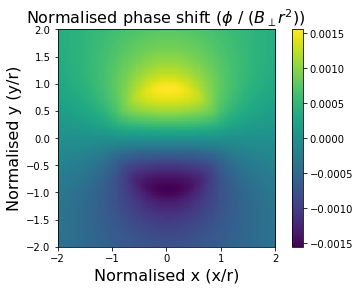

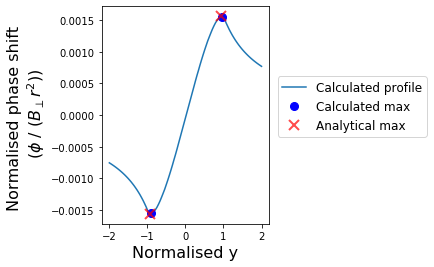

In [130]:
# De Graef, Nuhfer, 1999

# Phase change for a sphere
MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=100,Ms_Am=convertmag_T_Am(1.6),bbox_length_m=200*1e-9)
phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params,n_pad=500)

# Normalised phase change
C = (np.max(phase)-np.min(phase))*322.0464
plt.imshow(phase.T/C,extent=(-2,2,-2,2))
plt.colorbar()
plt.xlabel('Normalised x (x/r)',fontsize=16)
plt.ylabel('Normalised y (y/r)',fontsize=16)
plt.title('Normalised phase shift ($\phi$ / ($B_\perp r^2$))',fontsize=16)
plt.show()

# Line profile across (0,y)
plt.figure(figsize=(3,4))
xs = np.linspace(-2,2,100)
plt.plot(np.linspace(-2,2,100),-phase[50,:]/C,'-',label='Calculated profile')

# 'where' function lets you see where calculated max is
#np.where(phase2/C==np.min(phase/C))
mx=phase2[50,27]/C
mn=phase2[50,73]/C
plt.plot([xs[27],xs[73]],[mn,mx],'bo',alpha=.99,markersize=8,label='Calculated max')

# Analytical values from the paper
plt.plot([-0.93,0.93],[-0.00156,0.00156],'rx',markersize=10,markeredgewidth=2,alpha=.7,label='Analytical max')
plt.xlabel('Normalised y',fontsize=16)
plt.ylabel('Normalised phase shift \n ($\phi$ / ($B_\perp r^2$))',fontsize=16)

plt.legend(fontsize=12,loc=(1.05,0.4))

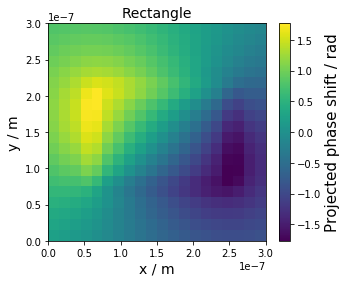

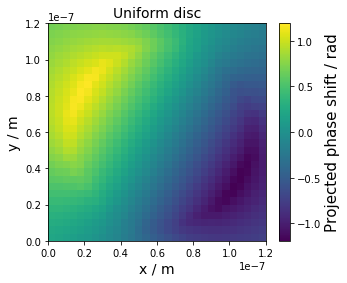

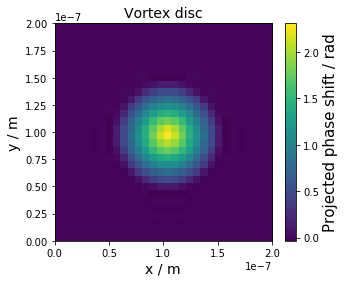

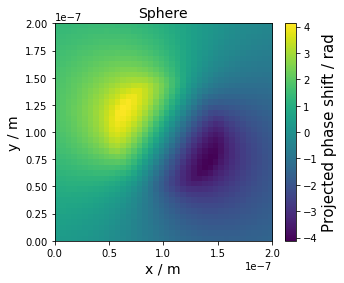

C:\Users\grl31\miniconda3\envs\astraenv\lib\site-packages\ipykernel_launcher.py:477: RuntimeWarning: divide by zero encountered in power


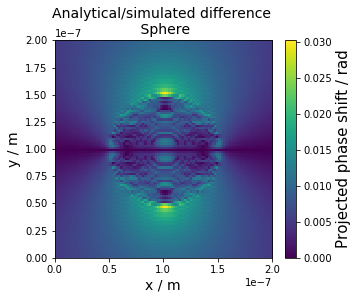

C:\Users\grl31\miniconda3\envs\astraenv\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in power


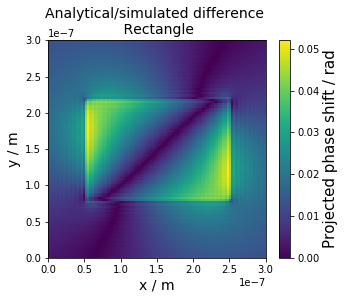

In [256]:
# Beleggia & Zhu, 2003
# rectangle
MX,MY,MZ,mesh_params=Magnetic_Phantom.rectangle(lx_m=200*1e-9,ly_m=140*1e-9,lz_m=20*1e-9,Ms_Am=convertmag_T_Am(1.6),
                                                plan_rot=300,p2=(300*1e-9,300*1e-9,50*1e-9),n=(20,20,20)) 
phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params)
plt.title('Rectangle',fontsize=14)
plot_phase_proj(phase,mesh_params=mesh_params)

# uniform disc
MX,MY,MZ,mesh_params= Magnetic_Phantom.disc_uniform(rad_m=50*1e-9,lz_m=20*1e-9,Ms_Am=convertmag_T_Am(1.6),bbox_length_m=120*1e-9,plan_rot=300,bbox_length_px=30)
phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params)
plt.title('Uniform disc',fontsize=14)
plot_phase_proj(phase,mesh_params=mesh_params)

# vortex disc
MX,MY,MZ,mesh_params= Magnetic_Phantom.disc_vortex(rad_m=50*1e-9,lz_m=20*1e-9,Ms_Am=convertmag_T_Am(1.6),bbox_length_m=200*1e-9,bbox_length_px=30)
phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params)
plt.title('Vortex disc',fontsize=14)
plot_phase_proj(phase,mesh_params=mesh_params)

# sphere
MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=40,Ms_Am=convertmag_T_Am(1.6),bbox_length_m=200*1e-9,plan_rot=300)
phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params)
plt.title('Sphere',fontsize=14)
plot_phase_proj(phase,mesh_params=mesh_params)

# analytical sphere difference
MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=100,Ms_Am=convertmag_T_Am(1.6),bbox_length_m=200*1e-9)
phase = try_2d(MX,MY,MZ,mesh_params,n_pad=500)
phase_analytical = analytical_sphere(mesh_params=mesh_params,r_m=5e-8,n_pad=500)
plt.title('Analytical/simulated difference \n Sphere',fontsize=14)
plot_phase_proj(abs(phase-phase_analytical),mesh_params=mesh_params)

# analytical rectangle difference
MX,MY,MZ,mesh_params=Magnetic_Phantom.rectangle(lx_m=200*1e-9,ly_m=140*1e-9,lz_m=20*1e-9,Ms_Am=convertmag_T_Am(1.6),
                                                plan_rot=300,p2=(300*1e-9,300*1e-9,50*1e-9),n=(100,100,100)) 
phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params,n_pad=500)
phase_analytical = analytical_rectangle(mesh_params=mesh_params,beta=300,n_pad=500)
plt.title('Analytical/simulated difference \n Rectangle',fontsize=14)
plot_phase_proj(abs(phase-phase_analytical),mesh_params=mesh_params)

Beginning phase calculation for 1791 voxels.
Running on 1 cpu.
0.00% .. 100.0%
total time: 0.36682 sec, 0.00020481 sec/voxel.


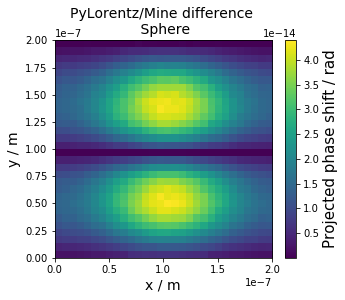

In [265]:
# McCray et al. 2021
# Generate magnetisation
bbox_length_m=200*1e-9
bbox_length_px=30
MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=bbox_length_px,Ms_Am=convertmag_T_Am(1.6),bbox_length_m=bbox_length_m)

# Pre-calculations for PyLorentz
pre_B = 2*np.pi * .5 * 4*np.pi*1e-7 /constants.codata.value('mag. flux quantum') * (bbox_length_m/bbox_length_px)**2
Dshp = np.hypot(MX,MY,MZ)

# PyLorentz calculation
_,mphi = linsupPhi(mx=np.transpose(MX,(2,1,0)), my=np.transpose(MY,(2,1,0)), mz=np.transpose(MZ,(2,1,0)), Dshp=Dshp, theta_x=0.0, theta_y=0.0, pre_B=pre_B, pre_E=1, v=1, multiproc=False)
mphi=-mphi.T # seem to have different convention

# my calculation
phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params,n_pad=0)

# Plot
plt.title('PyLorentz/Mine difference \n Sphere',fontsize=14)
plot_phase_proj(abs(phase-mphi),mesh_params=mesh_params)

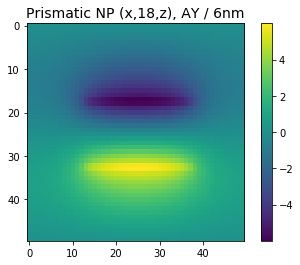

Text(0.5, 1.0, 'Cylindrical NP (x,15,z), AX / 6nm')

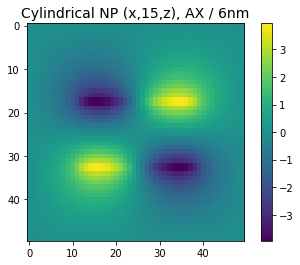

In [283]:
# Prabhat et  2017
# Prismatic (x,18,z)
MX,MY,MZ,mesh_params=Magnetic_Phantom.rectangle(lx_m=50*1e-9,ly_m=50*1e-9,lz_m=30*1e-9,plan_rot=30,p2=(100*1e-9,100*1e-9,100*1e-9),n=(50,50,50))
AX,AY,AZ,mesh_params2=calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=0)
plt.imshow(-AY[:,int((50+18)/2),:].T/(6*1e-9))
plt.colorbar()
np.max(AY[:,int((50+18)/2),:].T/(6*1e-9))
plt.title('Prismatic NP (x,18,z), AY / 6nm',fontsize=14)
plt.show()

# Cylindrical (x,15,z)
MX,MY,MZ,mesh_params=Magnetic_Phantom.disc_vortex(rad_m=30*1e-9,lz_m=30*1e-9,bbox_length_m=100*1e-9,bbox_length_px=50)
AX,AY,AZ,mesh_params2=calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=0)
plt.imshow(AX[:,int((50+15)/2),:].T/(6*1e-9))
plt.colorbar()
np.max(AX[:,int((50+15)/2),:].T/(6*1e-9))
plt.title('Cylindrical NP (x,15,z), AX / 6nm',fontsize=14)

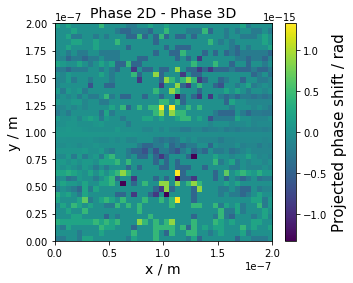

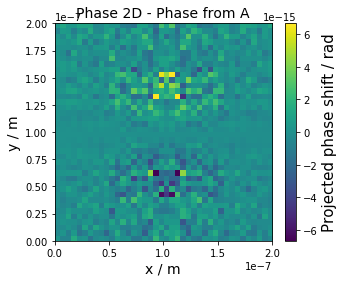

In [286]:
# Sanity check - phase calculations for direct 2D, direct 3D or 3D via A
MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=40,Ms_Am=convertmag_T_Am(1.6),bbox_length_m=200*1e-9)

phase_2D = calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
phase_3D = calculate_phase_M_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
AX,AY,AZ,mesh_params2 = calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
phase_A = calculate_phase_AZ(AZ,mesh_params=mesh_params2)

plt.title('Phase 2D - Phase 3D',fontsize=14)
plot_phase_proj(phase_2D-phase_3D,mesh_params=mesh_params)

plt.title('Phase 2D - Phase from A',fontsize=14)
plot_phase_proj(phase_2D-phase_A[100:-100,100:-100],mesh_params=mesh_params)

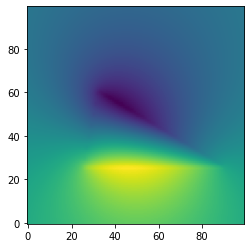

In [124]:
# sanity check - orientation
# MX,MY,MZ,mesh_params=Magnetic_Phantom.tri_pris()
# mx,my=project_along_z(MX,mesh_params=mesh_params),project_along_z(MY,mesh_params=mesh_params)
# plot_2d_mag(mx,my,mesh_params=mesh_params,s=5)

# phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params)
#plot_phase_proj(phase[:,::-1],mesh_params=mesh_params)
plt.imshow(phase.T,origin='lower')

In [156]:
# B calculations

def calculate_B_from_A(AX,AY,AZ,mesh_params=None):
    """ Takes curl of B to get A """
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    p1,p2,n=mesh_params
    
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 
    
    BX = np.gradient(AZ,resy)[1] - np.gradient(AY,resz)[2]
    BY = np.gradient(AX,resz)[2] - np.gradient(AZ,resx)[0]
    BZ = np.gradient(AY,resx)[0] - np.gradient(AX,resy)[1]
        
    return BX/(2*np.pi),BY/(2*np.pi),BZ/(2*np.pi)

def calculate_B_from_phase(phase_B,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    d_phase = np.gradient(phase_B,x_res)
    b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
    b_field_x = -b_const*d_phase[1]
    b_field_y = b_const*d_phase[0]

    mag_B = np.hypot(b_field_x,b_field_y)
    
    return mag_B,b_field_x,b_field_y


## B checks - Boureau et al 2021

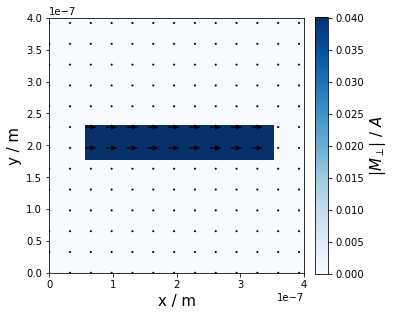

In [324]:
# Magnetisation
MX,MY,MZ,mesh_params = Magnetic_Phantom.rectangle(lx_m=300*1e-9,ly_m=56*1e-9,lz_m=56*1e-9,n=(50,50,50),Ms_Am=convertmag_T_Am(.9),p2=(400*1e-9,400*1e-9,400*1e-9))
mx,my=project_along_z(MX,mesh_params=mesh_params),project_along_z(MY,mesh_params=mesh_params)
plot_2d_mag(mx,my,mesh_params=mesh_params,s=4)

In [6]:
# Calculate B in 3D from A
AX,AY,AZ,mesh_params2 = calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
BX,BY,BZ = calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params)

In [7]:
# Calculate projection of B along Z
bxa,bya = project_along_z(BX,mesh_params=mesh_params2),project_along_z(BY,mesh_params=mesh_params2)
n=100
bxa,bya=bxa[n:-n,n:-n],bya[n:-n,n:-n]
bmaga=np.hypot(bxa,bya)

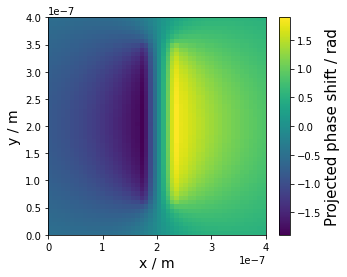

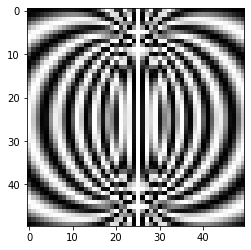

Text(0.5, 0, 'Distance/ nm')

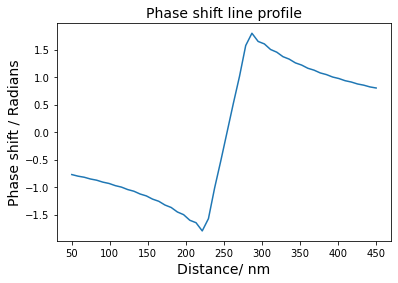

In [326]:
# calculate projected B from phase shift
phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
bmag,bx,by = calculate_B_from_phase(phase,mesh_params=mesh_params)

plot_phase_proj(-phase.T,mesh_params=mesh_params)

plt.imshow(np.cos(phase*30),cmap='gray')
plt.show()

xs = np.linspace(50,450)
plt.plot(xs,-phase[15,:])
plt.title('Phase shift line profile',fontsize=14)
plt.ylabel('Phase shift / Radians',fontsize=14)
plt.xlabel('Distance/ nm',fontsize=14)

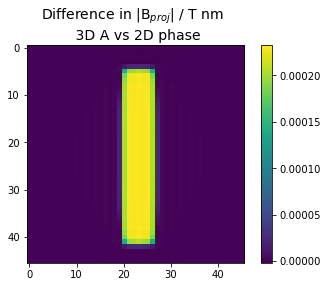

In [9]:
# Compare calculation of B_proj from 3D A vs from 2D phase
plt.imshow(((bmaga[2:-2,2:-2]*1e9-bmag[2:-2,2:-2]*1e9).T).T)
plt.title('Difference in |B$_{proj}$| / T nm  \n 3D A vs 2D phase',fontsize=14)
plt.colorbar()

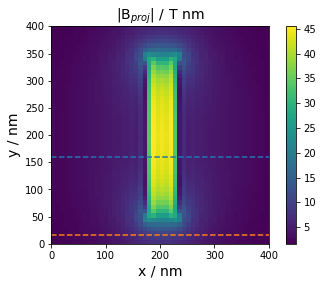

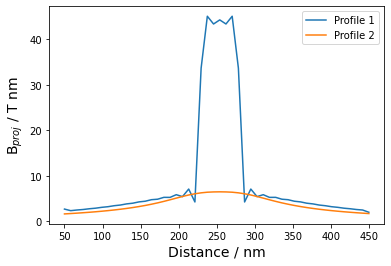

In [10]:
plt.imshow(bmag*1e9,extent=[0,400,0,400])
plt.colorbar()
plt.title('|B$_{proj}$| / T nm',fontsize=14)
plt.xlabel('x / nm',fontsize=14)
plt.ylabel('y / nm',fontsize=14)

plt.plot([0,400],[160,160],'--')
plt.plot([0,400],[16,16],'--')

plt.show()

xs = np.linspace(50,450)
plt.plot(xs,bmag[20,:]*1e9)
plt.plot(xs,bmag[0,:]*1e9)

plt.xlabel('Distance / nm',fontsize=14)
plt.ylabel('B$_{proj}$ / T nm',fontsize=14)
plt.legend(['Profile 1', 'Profile 2'])

## Stuff
- checking B
- checking orientation
- plotting

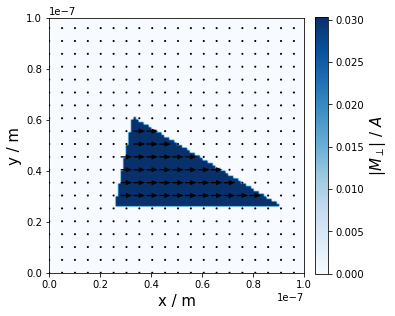

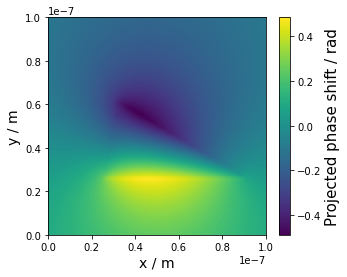

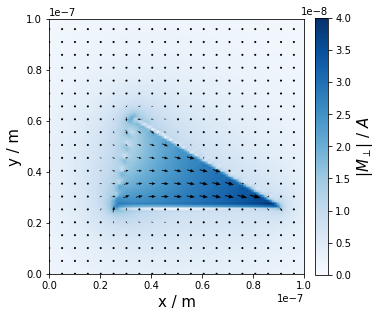

In [184]:
# sanity check - orientation
MX,MY,MZ,mesh_params=Magnetic_Phantom.tri_pris()
mx,my=project_along_z(MX,mesh_params=mesh_params),project_along_z(MY,mesh_params=mesh_params)
plot_2d_mag(mx,my,mesh_params=mesh_params,s=5)
bmag,bx,by = calculate_B_from_phase(phase,mesh_params=mesh_params)

phase = calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params)
plot_phase_proj(phase,mesh_params=mesh_params)
plot_2d_mag(bx,by,mesh_params=mesh_params,s=5)

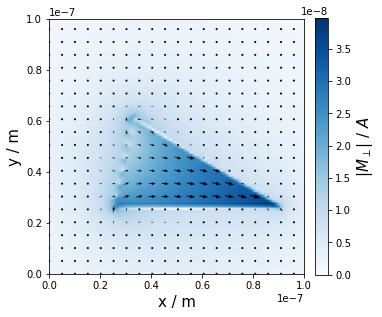

In [162]:
AX,AY,AZ,mesh_params2 = calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
BX,BY,BZ = calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params)
bxa,bya = project_along_z(BX,mesh_params=mesh_params2),project_along_z(BY,mesh_params=mesh_params2)
n=100
bxa,bya=bxa[n:-n,n:-n],bya[n:-n,n:-n]
bmaga=np.hypot(bxa,bya)
plot_2d_mag(bxa,bya,mesh_params=mesh_params,s=5)

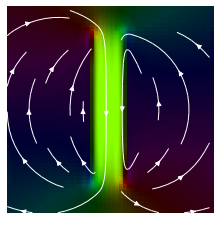

In [12]:
def plot_rafal(b_field_x,b_field_y,mag_B,ax1=None,mesh_params=None):
    if ax1 == None:
        plt.figure()
        ax1 = plt.gca()
    skip_arrow = 5
    size_arrow = 0.25
    angle = 0
    
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(b_field_x)
        p2 = (s[0],s[1],s[0])
        n = p2
        
    x_begin,x_end = p1[0],p2[0]
    y_begin,y_end = p1[1],p2[1]
    
    # cmap
    import matplotlib.colors
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as patches
    cvals  = [-2., 2]
    colors = ["black","black"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))
    # Set alpha
    my_cmap[int(0.15*cmap.N):int(0.95*cmap.N),-1] = np.linspace(1, 0, int(0.8*cmap.N+1))
    my_cmap[int(0.95*cmap.N):,-1] = np.ones_like(my_cmap[int(0.95*cmap.N):,-1])*0
    # Create new colormap
    my_cmap = ListedColormap(my_cmap)

    # plot B field direction as a colour
    ax1.imshow(ndimage.rotate(np.arctan2(b_field_y,b_field_x).T,-90),origin='lower', 
               extent=[x_begin, x_end, y_begin,y_end], cmap='hsv')

    # Plot magnitude of B as in black/transparent scale
    ax1.imshow(ndimage.rotate(mag_B.T,-90),origin='lower', 
               extent=[x_begin, x_end, y_begin,y_end],interpolation='spline16', cmap=my_cmap,alpha=.8)

    #ax1.set_title(r'$\bf{B}$$_\perp$', fontsize=25)
    ax1.set_xlabel('x', fontsize = 16)
    ax1.set_ylabel('y', fontsize = 16)



    ax1.axis('off')
    
plot_rafal(bx,by,bmag)

xx=np.arange(50)
x,y = np.meshgrid(xx,xx)
plt.streamplot(x,y,bx,by,density=.3,color='white',linewidth=1,cmap='RdBu')

In [131]:
def alpha_cmap():
    """ Returns a colormap object that is black,
    with alpha=1 at vmin and alpha=0 at vmax"""
    # Create a colour map which is just black
    colors = [(0.0, 'black'), (1.0, 'black')]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("alpha_cmap", colors)
    # Get colors from current map for values 1 to 256
    # These will all be black with alpha=1 (opaque), ie. [0,0,0,1]
    my_cmap = cmap(np.arange(cmap.N))
    # Set alpha (opaque and black (1) at vmin and fully transparanet at vmax)
    my_cmap[:,-1] = np.linspace(1,0,cmap.N)
    # create new colormap with the new alpha values
    my_cmap = ListedColormap(my_cmap)
    
    return my_cmap

In [404]:
# cmap
import matplotlib.colors
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches


def plot_2d_B(bx,by,mesh_params=None, ax=None,s=5,scale=7,mag_res=5, quiver=True, B_contour=True,phase=None,phase_res=np.pi/50):
    if ax == None:
        fig,ax = plt.subplots()
    
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(b_field_x)
        p2 = (s[0],s[1],s[0])
        n = p2
        mesh_params = [p1,p2,n]
    
    p1,p2,n = mesh_params
    mag_B = np.hypot(bx,by)

    # Create alpha contour map
    my_cmap = alpha_cmap()

    # plot B field direction as a colour
    # using tan-1(vy/vx)
    angles = np.arctan2(by,bx)
    angles = shift_angles(angles,np.pi)
    ax.imshow(angles.T,origin='lower', 
               extent=[p1[0], p2[0], p1[1],p2[1]], cmap='hsv')

    # Plot magnitude of B as in black/transparent scale
    ax.imshow(mag_B.T,origin='lower', 
               extent=[p1[0], p2[0], p1[1],p2[1]],interpolation='spline16', cmap=my_cmap,alpha=1)

    ax.set_xlabel('x / m', fontsize = 16)
    ax.set_ylabel('y / m', fontsize = 16)
    
    # Quiver plot of Bx,By
    if quiver==True:
        x = np.linspace(p1[0],p2[0],num=n[0])
        y = np.linspace(p1[1],p2[1],num=n[1])
        xs,ys = np.meshgrid(x,y)
        ax.quiver(xs[::s,::s],ys[::s,::s],bx[::s,::s].T,by[::s,::s].T,color='white',scale=np.max(abs(mag_B))*scale,
                  pivot='mid',width=0.009,headaxislength=5,headwidth=4,minshaft=1.8)
    
    # Contour plot of |B|
    if B_contour==True:
        mag_range = (np.max(mag_B)-np.min(mag_B))/1e-9
        n_levels = int(mag_range/mag_res)
        cs = ax.contour(mag_B.T,origin='lower',levels=10, extent=[p1[0], p2[0], p1[1],p2[1]], alpha = .3,colors='white')
        
    # Contour plot of phase
    if type(phase)!=type(None):
        phase_range = (np.max(phase)-np.min(phase))/1e-9
        n_levels = int(phase_range/phase_res)
        cs = ax.contour(phase.T-np.min(phase).T,origin='lower',levels=10, extent=[p1[0], p2[0], p1[1],p2[1]], alpha = .3,colors='white')

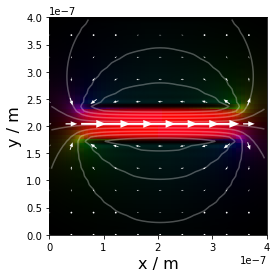

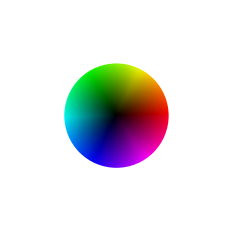

In [407]:
plot_2d_B(bx,by,mesh_params=mesh_params,phase=phase,B_contour=False)
plot_colorwheel()

In [375]:

def shift_angles(vals,angle=None):
    """ Takes angles currently in -pi to +pi range,
    and lets you shift them by an angle, keeping them
    in the same range."""
    
    if angle == None:
        return vals
    
    newvals = vals+angle
    for i,vv in enumerate(newvals):
        for j,v in enumerate(vv):
            if v > np.pi:
                newvals[i,j] = v - 2*np.pi
            if v < -np.pi:
                newvals[i,j] = v + 2*np.pi
            
    return newvals

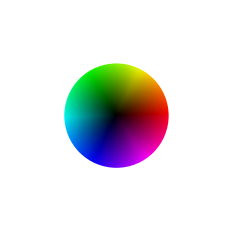

In [393]:

def plot_colorwheel(alpha=1,rot=0,flip= False):
    """ Plots a colorwheel"""
    def cart2pol(x, y):
        """ Convert cartesian to polar coordinates
        rho = magnitude, phi = angle """
        rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        return(rho, phi)

    fig,ax = plt.subplots()

    # Create coordinate space
    x = np.linspace(-1,1,200)
    y = x
    X,Y = np.meshgrid(x,y)

    # Map theta values onto coordinate space 
    thetas = np.ones_like(X)*0
    for ix, xx in enumerate(x):
        for iy, yy in enumerate(y):
            thetas[ix,iy] = cart2pol(xx,yy)[1]

    # Plot hsv colormap of angles
    if flip == False:
        im1 = ax.imshow(ndimage.rotate(thetas.T,180+rot),cmap='hsv_r',origin='lower')
    if flip == True:
        im1 = ax.imshow(ndimage.rotate(thetas,270+rot),cmap='hsv_r',origin='lower')

    # Create alpha contour map
    my_cmap = alpha_cmap()

    # Map circle radii onto xy coordinate space
    circ = np.ones_like(X)*0
    for ix, xx in enumerate(x):
        for iy, yy in enumerate(y):
            if xx**2 + yy**2 < 0.5**2:
                circ[ix,iy] = cart2pol(xx,yy)[0]

    # Plot circle
    im2 = plt.imshow(circ, cmap=my_cmap,alpha=alpha)

    # Clip to make it circular
    patch = patches.Circle((100, 100), radius=48, transform=ax.transData)
    im2.set_clip_path(patch)
    im1.set_clip_path(patch)

    ax.axis('off')
    plt.show()
    
plot_colorwheel(flip=False)

## BBox/padding tests

In [407]:
all_ps=[]
for px in [20,30,40,50,60,70,80]:
    MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=px,Ms_Am=convertmag_T_Am(1.6),bbox_length_m=200*1e-9)
    ps=[]
    for n_pad in [0,5,10,30,50,75,100,300,500]:
        p = try_2d(MX,MY,MZ,mesh_params,n_pad=n_pad)
        ps.append(np.max(p))
    all_ps.append(ps)

Text(0, 0.5, 'Maximum phase shift / rads')

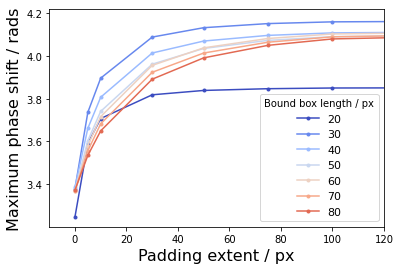

In [411]:
import matplotlib
cmap = matplotlib.cm.get_cmap('coolwarm')
for i, px in enumerate([20,30,40,50,60,70,80]):
    c=cmap(i/7)
    plt.plot([0,5,10,30,50,75,100,300,500],all_ps[i],'.-',label=px,color=c)
#     g = np.gradient(all_ps[i])
#     g = np.gradient(g)
#     plt.plot([0,5,10,30,50,75,100,300,500],g,label=px)
    
plt.legend(title='Bound box length / px',fontsize=11)
plt.xlim([-10,120])
plt.xlabel('Padding extent / px',fontsize=16)
plt.ylabel('Maximum phase shift / rads',fontsize=16)

In [46]:

ps = []

for f in [0,0.01,0.1,1,10,20,40,60,80]:
    #MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=int(l/2),Ms_Am=convertmag_T_Am(1.6),bbox_length_m=l*1e-9)
    phase2 = try_2d(MX,MY,MZ,mesh_params,n_pad=500,tik_filter=f)
    ps.append(np.max(phase2))

<ipython-input-25-564ffdc5e76c>:32: RuntimeWarning: divide by zero encountered in power
  K2_inv = np.nan_to_num(((KX**2+KY**2)**.5)**-2)


<ipython-input-70-fa1b2c7a54e2>:5: RuntimeWarning: divide by zero encountered in power
  np.nan_to_num(np.array([0.0,1.0,2.0])**-2)


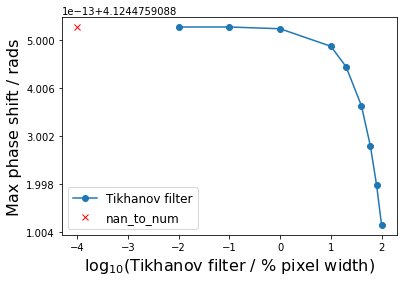

In [70]:
plt.plot(np.log10([0.01,0.1,1,10,20,40,60,80,100]),ps[1:],'-o',label='Tikhanov filter')
plt.plot(-4,ps[0],'rx',label='nan_to_num')
plt.xlabel('log$_{10}$(Tikhanov filter / % pixel width)',fontsize=16)
plt.ylabel('Max phase shift / rads',fontsize=16)
np.nan_to_num(np.array([0.0,1.0,2.0])**-2)
plt.legend(fontsize=12)

In [5]:
import time
ps = []
ts = []
for n_pad in [0,1,10,50,100,200,400,600,800,1000,1500,2000]:
    #MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=int(l/2),Ms_Am=convertmag_T_Am(1.6),bbox_length_m=l*1e-9)
    ti = time.time()
    phase2 = try_2d(MX,MY,MZ,mesh_params,n_pad=n_pad)
    tf = time.time()
    tot = tf-ti
    ts.append(tot)
    ps.append(np.max(phase2))

<ipython-input-3-35a0aece1ecf>:30: RuntimeWarning: divide by zero encountered in power
  K2_inv = np.nan_to_num(((KX**2+KY**2)**.5)**-2)


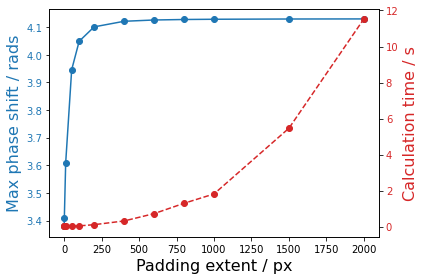

In [20]:
xs = [0,1,10,50,100,200,400,600,800,1000,1500,2000]
xs=np.array(xs)
# plt.plot([0,1,10,50,100,200,400,600,800,1000,1500,2000],ps,'o-')

fig, ax1 = plt.subplots()

color = 'tab:blue'
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('Max phase shift / rads',fontsize=16, color=color)
ax1.plot(xs, ps,'-o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Calculation time / s',fontsize=16, color=color)  # we already handled the x-label with ax1
ax2.plot(xs, ts,'--o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlabel('Padding extent / px',fontsize=16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#plt.ylabel('Max phase shift / rads',fontsize=16)

In [419]:
ps = []
for l in range(60,150):
    MX,MY,MZ,mesh_params=Magnetic_Phantom.disc_vortex(rad_m=30*1e-9,lz_m=20*1e-9,bbox_length_px=int(l/2),Ms_Am=convertmag_T_Am(1.6),bbox_length_m=l*1e-9)
    phase = try_2d(MX,MY,MZ,mesh_params=mesh_params,n_pad=500)
    ps.append(np.max(phase))

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


Text(0.5, 1.0, 'Fixed 2 nm/px sampling rate, Padding = 500 px')

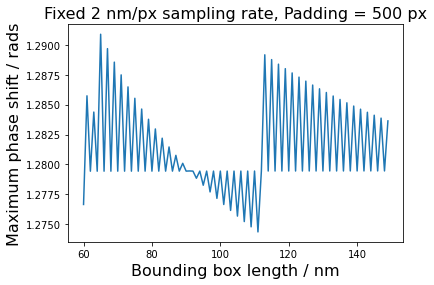

In [421]:
plt.plot(np.arange(60,150),ps)
plt.xlabel('Bounding box length / nm',fontsize=16)
plt.ylabel('Maximum phase shift / rads',fontsize=16)
plt.title('Fixed 2 nm/px sampling rate, Padding = 500 px',fontsize=16)

# N=10
# av = np.convolve(ps, np.ones(N)/N, mode='valid')
# plt.plot(np.arange(105,196),av,'r--')
# plt.legend(['Data','Moving average'],fontsize=12)


5.6807898228761236

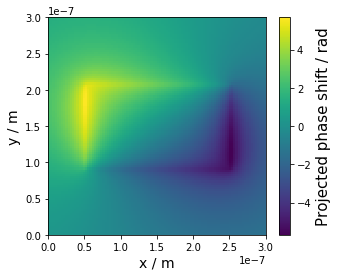

In [228]:
def calculate_phase_2(AX,AY,AZ, mesh_params=None):
    """ Alternative calculation of phase shift carried out in Fourier space """
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    p1,p2,n=mesh_params
    res = p2[2]/n[2]
    n_pad=0
    AZpad = np.pad(AZ,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)

    # take 3D FT of AZ    
    ft_AZ = np.fft.fftn(AZpad)
    
    # take slice
    aslice =  ft_AZ[:,:,0]
    
    # Calculate phase(k)
    pk = aslice * -1 * np.pi/constants.codata.value('mag. flux quantum')
    
    # transform to real space
    pr = np.fft.ifft2(pk).real*res

    return pr

p2 = calculate_phase_2(AX,AY,AZ,mesh_params=mesh_params)
#plt.imshow(p2)
plot_phase_proj(p2,mesh_params=mesh_params)
np.max(p2)

In [159]:
ps = []
As = []
#l = 300
n=500
r=5
for l in np.arange(200,1000,2):
    pa = analytical_rectangle(mesh_params=[(0,0,0),(l*1e-9,l*1e-9,l*1e-9),(n,n,n)])
    p = np.max(pa)#*(l/n)*1e9
    ps.append(p)
    
p5 = ps

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in power


Text(0.5, 1.0, 'Analytical')

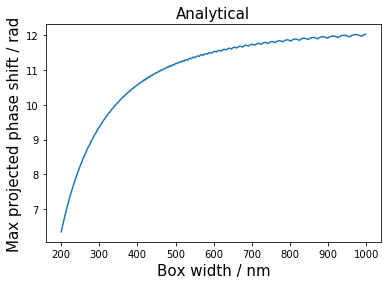

In [160]:
# plt.plot(np.arange(20,200)*15,p5,label='5 nm/px')
# plt.plot(np.arange(20,200)*15,p4,label='4 nm/px')
# plt.plot(np.arange(20,200)*15,p3,label='3 nm/px')
# plt.plot(np.arange(20,200)*15,p2,label='2 nm/px')
# plt.plot(np.arange(20,200)*15,p1,label='1 nm/px')
plt.plot(np.arange(200,1000,2),ps)
plt.xlabel('Box width / nm',fontsize=15)
plt.ylabel('Max projected phase shift / rad',fontsize=15)
plt.title('Analytical',fontsize=15)
#plt.legend(fontsize=12)

In [9]:
ps = []
As = []
for n in np.arange(20,100):
    MX,MY,MZ,mesh_params=Magnetic_Phantom.rectangle(lx_m=120*1e-9,ly_m=200*1e-9,lz_m=20*1e-9,
                                                    Ms_Am=convertmag_T_Am(1.6),plan_rot=300,bbox_length_m=300*1e-9,bbox_length_px=n) 
    AX,AY,AZ = calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params)
    phase = calculate_phase(AX,AY,AZ,mesh_params=mesh_params)
    p=np.max(phase)
    ps.append(p)
    a = np.max(AZ)
    As.append(a)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:289: RuntimeWarning: divide by zero encountered in power


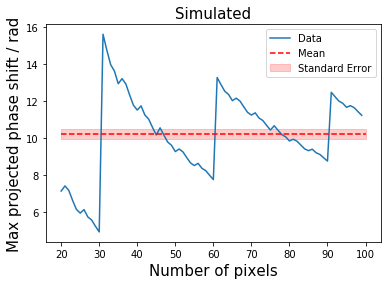

In [27]:
plt.plot(np.arange(20,100),ps,label='Data')
plt.xlabel('Number of pixels',fontsize=15)
plt.ylabel('Max projected phase shift / rad',fontsize=15)
plt.title('Simulated',fontsize=15)

from scipy.optimize import curve_fit

avg = np.mean(ps)
err = np.std(ps)/np.sqrt(np.shape(ps)[0])
plt.plot([20,100],[avg,avg],'r--',label='Mean')
plt.fill_between([20,100],[avg-err,avg-err],[avg+err,avg+err],color='r',alpha=.2,label='Standard Error')
plt.legend()

In [81]:
ps = np.array(ps)
taus = np.array([1,2,5,10,100])
k = constants.codata.value('mag. flux quantum')#/(np.pi*(10*1e-9)**2*1.6)#*4*np.pi*1e-7)
k*1e18

2067.833831

In [271]:
ps = []
for r in [10,50,100,200]:
    #MX,MY,MZ,mesh_params=Magnetic_Phantom.rod(lx_m = 2*tau*1e-8, bbox_length_m=2*tau*1e-8*1.2,bbox_length_px=50)
    MX,MY,MZ,mesh_params=Magnetic_Phantom.disc(rad_m = r*1e-9, bbox_length_m=2.2*r*1e-9,bbox_length_px=50)
    mx = project_along_z(MX,mesh_params=mesh_params)
    my = project_along_z(MY,mesh_params=mesh_params)
    #plot_2d_mag(mx,my,mesh_params=mesh_params,s=5)
    AX,AY,AZ = A_calc_3D(MX,MY,MZ,mesh_params=mesh_params)
    phase = calculate_phase(AX,AY,AZ,mesh_params=mesh_params)
    ps.append(np.max(phase))

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


Text(0.5, 1.0, 'Vortex disk')

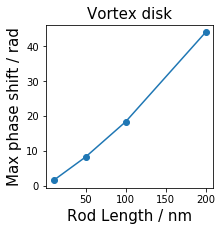

In [272]:
plt.figure(figsize=(3,3))
plt.plot([10,50,100,200],ps,'o-')
plt.xlabel('Rod Length / nm',fontsize=15)
plt.ylabel('Max phase shift / rad',fontsize=15)
plt.title('Vortex disk',fontsize=15)

In [407]:
def rotate_bulk(P,ax,ay,az):
    """ 
    Rotate magnetisation locations from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    
    NOTE: This implementation of scipy rotations is EXTRINSIC
    Therefore, to make it compatible with our intrinsic vector
    rotation, we swap the order of rotations (i.e. x then y then z)
    """
    # Due to indexing, ay needs reversing for desired behaviour
    ay = -ay
    
    P = ndimage.rotate(P,ax,reshape=False,axes=(1,2),order=1)
    P = ndimage.rotate(P,ay,reshape=False,axes=(2,0),order=1)
    P = ndimage.rotate(P,az,reshape=False,axes=(0,1),order=1)

    return P


def grid_to_coor(U,V,W):
    """ Convert gridded 3D data (3,n,n,n) into coordinates (n^3, 3) """
    coor_flat = []
    nx = np.shape(U)[0]
    ny = np.shape(U)[1]
    nz = np.shape(U)[2]
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                x = U[ix,iy,iz]
                y = V[ix,iy,iz]
                z = W[ix,iy,iz]
                coor_flat.append([x,y,z])
                
    return coor_flat

def coor_to_grid(coor_flat,shape=None):
    """ Convert coordinates (n^3, 3) into gridded 3D data (3,n,n,n) """
    if shape == None:
        n = int(np.round(np.shape(coor_flat)[0]**(1/3)))
        shape = (n,n,n)
    nx,ny,nz = shape
    
    x = np.take(coor_flat,0,axis=1)
    y = np.take(coor_flat,1,axis=1)
    z = np.take(coor_flat,2,axis=1)
    U = x.reshape((nx,ny,nz))
    V = y.reshape((nx,ny,nz))
    W = z.reshape((nx,ny,nz))

    return U, V, W

def rotation_matrix(ax,ay,az):
    """ 
    Generate 3D rotation matrix from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """

    ax = ax * np.pi/180
    Cx = np.cos(ax)
    Sx = np.sin(ax)
    mrotx = np.array([[1,0,0],[0,Cx,-Sx],[0,Sx,Cx]])
    
    ay = ay * np.pi/180
    Cy = np.cos(ay)
    Sy = np.sin(ay)
    mroty = np.array([[Cy,0,Sy],[0,1,0],[-Sy,0,Cy]])
    
    az = az * np.pi/180
    Cz = np.cos(az)
    Sz = np.sin(az)
    mrotz = np.array([[Cz,-Sz,0],[Sz,Cz,0],[0,0,1]])
    
    mrot = mrotz.dot(mroty).dot(mrotx)
    
    return mrot

def rotate_vector(coor_flat,ax,ay,az):
    """ Rotates vectors by specified angles ax,ay,az 
    about the x,y,z axes (given in degrees) """
    
    # Get rotation matrix
    mrot = rotation_matrix(ax,ay,az)    

    coor_flat_r = np.zeros_like(coor_flat)
    
    # Apply rotation matrix to each M vector
    for i,M in enumerate(coor_flat):
        coor_flat_r[i] = mrot.dot(M)
    
    return coor_flat_r

def rotate_magnetisation(U,V,W,ax=0,ay=0,az=0):
    """ 
    Takes 3D gridded magnetisation values as input
    and returns them after an intrinsic rotation ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """
    # Rotate the gridded locations of M values
    Ub = rotate_bulk(U,ax,ay,az)
    Vb = rotate_bulk(V,ax,ay,az)
    Wb = rotate_bulk(W,ax,ay,az)
    
    shape = np.shape(Ub)
    
    # Convert gridded values to vectors
    coor_flat = grid_to_coor(Ub,Vb,Wb)
    
    # Rotate vectors
    coor_flat_r = rotate_vector(coor_flat,ax,ay,az)
    
    # Convert vectors back to gridded values
    Ur,Vr,Wr = coor_to_grid(coor_flat_r,shape=shape)
    
    # Set small values to 0
    # (In theory the magnitude of M in each cell should be Ms,
    #  so we can set magnitude lower than this to zero -
    #  typically python rounding errors lead to very small values,
    #  which it is useful to exclude here)
    mag_max = (np.max(U)**2+np.max(V)**2+np.max(W)**2)**0.5
    mag = (Ur**2+Vr**2+Wr**2)**.5
#     for M in [Ur,Vr,Wr]:
#         M[abs(M)<1e-5*mag_max] = 0
#         M[mag<.6*mag_max] = 0
    
    return Ur,Vr,Wr

def project_along_z(U,V,W,mesh_params=None):
#     u_proj = np.mean(U,axis=2)
#     v_proj = np.mean(V,axis=2)
#     w_proj = np.mean(W,axis=2)

    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(U)
        p2 = (sx,sy,sz)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    z_size = p2[2]
    z_res = z_size/n[2]
    
    u_proj = np.sum(U*z_res,axis=2)
    v_proj = np.sum(V*z_res,axis=2)
    w_proj = np.sum(W*z_res,axis=2)
    
    return u_proj, v_proj, w_proj

def extract_z_slice(U,V,W, i_z_slice=None):
    # default to central slice
    if type(i_z_slice) == type(None):
        _,_,z_size = np.shape(W)
        i_z_slice = int(z_size/2)
        
    u_slice = U[:,:,i_z_slice]
    v_slice = V[:,:,i_z_slice]
    
    return u_slice,v_slice

def generate_phase_data(MX,MY,MZ,angles,mesh_params=None):
    """ Returns phase projections for given M and angles
    in order [x, i_tilt, y] """
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(MX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    # Loop through projection angles
    for i in range(len(angles)):
        ax,ay,az = angles[i]
        #rotate M
        MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,ax,ay,az)
        # calculate A
        AX,AY,AZ = A_calc_3D(MXr,MYr,MZr,mesh_params=mesh_params)
        
        # calculate phase projection
        phase = calculate_phase(AX,AY,AZ,mesh_params=mesh_params)

        phase_projs.append(phase)            
    
#    # Prepare projections for reconstruction
#    raw_data = np.array(M_projs)
#     raw_data = raw_data -  raw_data.min()
#     raw_data = raw_data/raw_data.max()
    phase_projs = np.transpose(phase_projs,axes=[1,0,2]) # reshape so proj is middle column
        
    return np.array(phase_projs)

def plot_rafal(b_field_x,b_field_y,mag_B,ax1=None,mesh_params=None):
    if ax1 == None:
        plt.figure()
        ax1 = plt.gca()
    skip_arrow = 5
    size_arrow = 0.25
    angle = 0
    
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(b_field_x)
        p2 = (s[0],s[1],s[0])
        n = p2
        
    x_begin,x_end = p1[0],p2[0]
    y_begin,y_end = p1[1],p2[1]
    
    # cmap
    import matplotlib.colors
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as patches
    cvals  = [-2., 2]
    colors = ["black","black"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))
    # Set alpha
    my_cmap[int(0.15*cmap.N):int(0.95*cmap.N),-1] = np.linspace(1, 0, 0.8*cmap.N+1)
    my_cmap[int(0.95*cmap.N):,-1] = np.ones_like(my_cmap[int(0.95*cmap.N):,-1])*0
    # Create new colormap
    my_cmap = ListedColormap(my_cmap)

    # plot B field direction as a colour
    ax1.imshow(ndimage.rotate(np.arctan2(b_field_y,b_field_x).T,-90),origin='lower', 
               extent=[x_begin, x_end, y_begin,y_end], cmap='hsv')

    # Plot magnitude of B as in black/transparent scale
    ax1.imshow(ndimage.rotate(mag_B.T,-90),origin='lower', 
               extent=[x_begin, x_end, y_begin,y_end],interpolation='spline16', cmap=my_cmap)

    #ax1.set_title(r'$\bf{B}$$_\perp$', fontsize=25)
    ax1.set_xlabel('x', fontsize = 16)
    ax1.set_ylabel('y', fontsize = 16)



    ax1.axis('off')

In [77]:
def calculate_B(phase_B,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    d_phase = np.gradient(phase_B)
    b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
    b_field_x = -b_const*d_phase[0]#/y_res
    b_field_y = b_const*d_phase[1]#/x_res

    mag_B = np.hypot(b_field_x,b_field_y)
    
    return mag_B,b_field_x,b_field_y



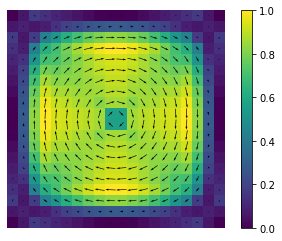

In [78]:
mag_B,b_field_x,b_field_y = calculate_B(phase,mesh_params=mesh_params)
plt.imshow(mag_B,origin='lower')
plt.quiver(b_field_x,b_field_y,pivot='mid')
plt.axis('off')
plt.colorbar()

## Reconstruction

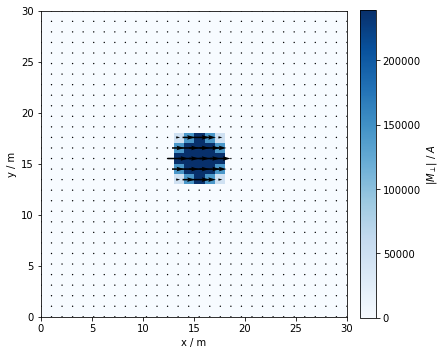

In [23]:
# Load micromagnetic input model
# generate cobalt sphere 6 nm diam
size_n= 30*1e-9
p1=(0.0, 0.0, 0.0)
p2=(size_n,size_n,size_n)
n=(30, 30, 30)

xs = np.linspace(0,size_n,num=n[0])
ys = np.linspace(0,size_n,num=n[0])
zs = np.linspace(0,size_n,num=n[0])

Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')
for i,a in enumerate(Mxx):
    for j,b in enumerate(a):
        for k,c in enumerate(b):
            if (i-15)**2 + (j-15)**2 + (k-15)**2 < 3**2:
                Mxx[i,j,k] = 1435860 * 1 # cobalt 
MX,MY,MZ = Mxx,Myy,Mzz
mesh_params = [p1,p2,n]

plot_2d_mag(np.mean(MX,axis=2).T,np.mean(MY,axis=2).T)

In [202]:
# calculate B from M
def calculate_B_from_A(AX,AY,AZ,mesh_params=None):
    """ Returns phase projections for given M and angles"""
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    BX = np.gradient(AZ)[1] - np.gradient(AY)[2]
    BY = np.gradient(AX)[2] - np.gradient(AZ)[0]
    BZ = np.gradient(AY)[0] - np.gradient(AX)[1]
        
    return BX,BY,BZ

def A_calc_3D(MX,MY,MZ, mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(MX)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
    
    # pad M to avoid artefacts
    n_pad = np.shape(MX)[0]
    mxpad = np.pad(MX,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mypad = np.pad(MY,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mzpad = np.pad(MZ,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)

    # take FT of M_proj
    # M_proj has units of (A/m) * m
    # i.e. integrated along z
    # i.e. each m corresponds to z_res thickness
    #z_size = p2[2]
    #z_res = z_size/n[2]
    
    ft_mx = np.fft.fftn(mxpad)
    ft_my = np.fft.fftn(mypad)
    ft_mz = np.fft.fftn(mzpad)
    
    # Generate K values
    x_size = p2[0]
    x_res = x_size/n[0]

    kx = np.fft.fftfreq(ft_mx.shape[0],d=x_res)
    ky,kz = kx,kx
    KX, KY, KZ = np.meshgrid(kz,ky,kx, indexing='ij') # Create a grid of coordinates
    
    # vacuum permeability
    mu0 = 4*np.pi*1e-7
    
    # 1/k^2 
    K2_inv = np.nan_to_num(((KX**2+KY**2+KZ**2)**.5)**-2)
    #k_filter = (1/x_size*x_res) * 0.01
    #K2_inv = ((KX**2+KY**2)**.5 + k_filter*.1)**-2
    #K2_inv = ((KX**2)+(KY**2)) / ((KX**2)+(KY**2)+k_filter**2)**2
    #print(x_size)
    
    # M x K
    cross_x = ft_my*KZ - ft_mz*KY
    cross_y = -ft_mx*KZ + ft_mz*KX
    cross_z = -ft_my*KX + ft_mx*KY
    
    # Calculate A(k)
    ft_Ax = (-1j * mu0 * K2_inv) * cross_x
    ft_Ay = (-1j * mu0 * K2_inv) * cross_y
    ft_Az = (-1j * mu0 * K2_inv) * cross_z
    
    # Calculate A(x,y)
    Ax = np.fft.ifftn(ft_Ax)
    AX = Ax.real
    Ay = np.fft.ifftn(ft_Ay)
    AY = Ay.real
    Az = np.fft.ifftn(ft_Az)
    AZ = Az.real
    return AX[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad],AY[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad],AZ[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad]

AX,AY,AZ = A_calc_3D(MX,MY,MZ,mesh_params=mesh_params)
BX,BY,BZ = calculate_B_from_A(AX,AY,AZ ,mesh_params=mesh_params)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


Text(0.5, 1.0, 'Ay [x, 50+15, z] / T $\\bullet$ (6 nm)')

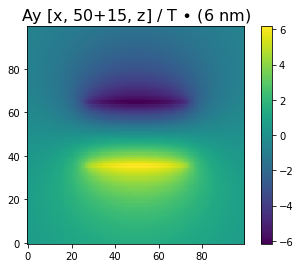

In [204]:
#plt.imshow(np.flipud(AY[:,65,:].T))
plt.imshow(AY[:,(50+18),:].T/(6*1e-9),origin='top')
plt.colorbar()
plt.title(r'Ay [x, 50+15, z] / T $\bullet$ (6 nm)',fontsize=16)

In [31]:
# Generate phase projection data
angles_x = ma.generate_angles(mode='x',n_tilt=10)
angles_y = ma.generate_angles(mode='y',n_tilt=10)
phases_x = generate_phase_data(MX,MY,MZ,angles_x,mesh_params=mesh_params)
phases_y = generate_phase_data(MX,MY,MZ,angles_y,mesh_params=mesh_params)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


In [39]:
# reconstruction 
vectors_x = ma.generate_vectors(angles_x)
recon = ma.generate_reconstruction(phases_x,vectors_x,algorithm='SIRT3D_CUDA',niter=30,callback_freq=5,weight=0.001)
recon_x = ma.reorient_reconstruction(recon)

vectors_y = ma.generate_vectors(angles_y)
recon = ma.generate_reconstruction(phases_y,vectors_y,algorithm='SIRT3D_CUDA',niter=30,callback_freq=5,weight=0.001)
recon_y = ma.reorient_reconstruction(recon)

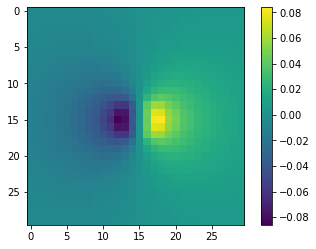

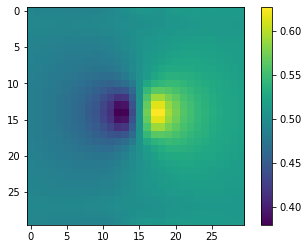

In [42]:
plt.imshow(phases_x[:,5,:])
plt.colorbar()
plt.show()
plt.imshow(np.mean(recon_x,axis=2).T)
plt.colorbar()

In [9]:
import tomopy

In [17]:
# basic reconstruction
theta = np.take(angles_x,0,axis=1) * np.pi/180
recon = tomopy.recon(phases_x, theta, algorithm='sirt',num_iter = 20)
recon = np.transpose(recon,axes=(0,2,1))
recon = recon[:,::-1,::-1]
recon_x = recon

recon = tomopy.recon(phases_y, theta, algorithm='sirt',num_iter = 20)
recon = np.transpose(recon,axes=(0,2,1))
recon = recon[:,::-1,::-1]
recon_y = recon

In [45]:
BXr,BYr,BZr = calculate_B_dual(recon_x,recon_y,mesh_params=mesh_params)

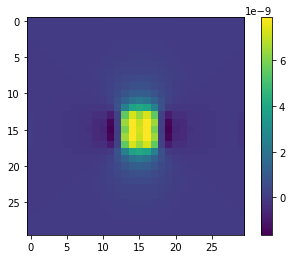

In [55]:
plt.imshow(BX[:,:,15])
plt.colorbar()

Text(0.5, 1.0, 'B[x,y,-1 nm]')

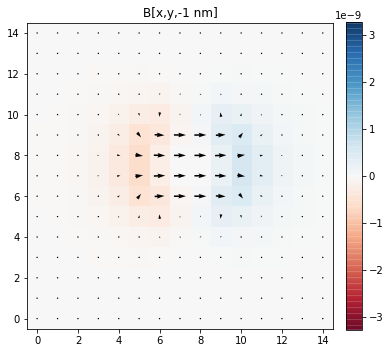

In [68]:
def plot_B(BX,BY,BZ,i_slice):
    plt.figure(figsize=(6,6))
    mag = (BX**2+BY**2+BZ**2)**.5
    mmax = np.max(mag)
    bx = BX[::2,::2,i_slice]
    by = BY[::2,::2,i_slice]
    bz = BZ[::2,::2,i_slice]
    plt.quiver(bx.T,by.T,pivot='mid',width=.005,scale=2e-7) # 60
    plt.imshow(bz.T,origin='top',cmap='RdBu',alpha=.8,vmin=-mmax*.4,vmax=mmax*.4)
    plt.colorbar(fraction=0.046, pad=0.04)
    
plot_B(BX,BY,BZ,16)
plt.title('B[x,y,-1 nm]')

In [44]:
def calculate_B_dual(PX,PY,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    BX,BY,BZ = [],[],[]
    
    for i in range(np.shape(PX)[2]):
        px = PX[:,:,i]
        py = PY[:,:,i]
        d_phase_x = np.gradient(px)
        d_phase_y = np.gradient(py)
        b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
        b_field_x = -b_const*d_phase_x[0]#/y_res
        b_field_y = b_const*d_phase_y[1]#/x_res
        b_field_z = -1*(np.gradient(b_field_x)[0]+np.gradient(b_field_y)[1])
        
        BX.append(b_field_x)
        BY.append(b_field_y)
        BZ.append(b_field_z)
    
    return np.array(BX),np.array(BY),np.array(BZ)

In [ ]:
# intensity 
# beyond x/y

Text(0.5, 1.0, 'B(x,y,-1 nm)')

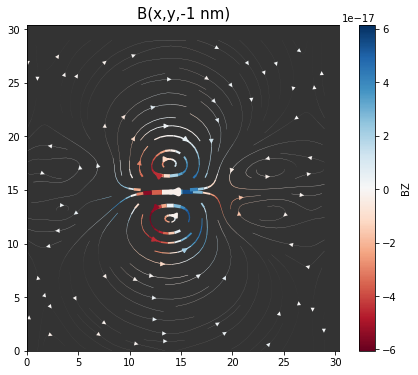

In [68]:
x=np.arange(30)
plt.figure(figsize=(7,6))
i=14
mag = (BXr.T[:,:,i].T**2 + BXr[:,:,i].T**2)**.5
col = BZr.T[:,:,i].T
lw = 5*mag/np.max(mag)
plt.streamplot(x,x,BXr.T[:,:,i].T,BYr.T[:,:,i].T,density=1,color=np.fliplr(col.T),linewidth=lw,cmap='RdBu')
ax = plt.gca()
ax.set_facecolor((0,0,0,.8))
cbar = plt.colorbar()
cbar.ax.set_ylabel('BZ')
plt.title('B(x,y,-1 nm)',fontsize=15)

In [71]:
xx=np.arange(30)

In [69]:
import chart_studio.plotly as py
import plotly.graph_objs as go

In [72]:
xx=np.arange(30)
x,y,z = np.meshgrid(xx,xx,xx)
u,v,w = BX,BY,BZ

In [73]:
pl_curl=[[0.0, 'rgb(20, 29, 67)'],# curl is a cmocean colormap 
         [0.05, 'rgb(25, 52, 80)'],
         [0.1, 'rgb(28, 76, 96)'],
         [0.15, 'rgb(23, 100, 110)'],
         [0.2, 'rgb(16, 125, 121)'],
         [0.25, 'rgb(44, 148, 127)'],
         [0.3, 'rgb(92, 166, 133)'],
         [0.35, 'rgb(140, 184, 150)'],
         [0.4, 'rgb(182, 202, 175)'],
         [0.45, 'rgb(220, 223, 208)'],
         [0.5, 'rgb(253, 245, 243)'],
         [0.55, 'rgb(240, 215, 203)'],
         [0.6, 'rgb(230, 183, 162)'],
         [0.65, 'rgb(221, 150, 127)'],
         [0.7, 'rgb(211, 118, 105)'],
         [0.75, 'rgb(194, 88, 96)'],
         [0.8, 'rgb(174, 63, 95)'],
         [0.85, 'rgb(147, 41, 96)'],
         [0.9, 'rgb(116, 25, 93)'],
         [0.95, 'rgb(82, 18, 77)'],
         [1.0, 'rgb(51, 13, 53)']]

In [74]:
cones = dict(type='cone',
              x=x.flatten(),
              y=y.flatten(), 
              z=z.flatten(), 
              u=u.flatten(), 
              v=v.flatten(), 
              w=w.flatten(), 
              sizemode='scaled',
              sizeref=2,
              showscale=True,
              colorscale=pl_curl, 
              colorbar=dict(thickness=20, ticklen=4, len=0.75), 
              anchor='tail'
          )

In [75]:
def get_layout(title='Cone  Plot', width=800, height=750, aspect=[1, 1, 0.9]):
    axis = dict(showbackground=True, 
                backgroundcolor="rgb(235, 235,235)",
                gridcolor="rgb(255, 255, 255)",      
                zerolinecolor="rgb(255, 255, 255)",
                )

    return   dict(title=title, 
                  width=width,
                  height=height,
                  autosize=False,
                  scene=dict(camera=dict(eye=dict(x=1.15, y=1.15, z=0.6)),
                             xaxis=dict(axis),
                             yaxis=dict(axis), 
                             zaxis=dict(axis),
                             aspectratio=dict(x=aspect[0],
                                              y=aspect[1],
                                              z=aspect[2]))
              )

In [81]:
fig1 = go.Figure(data=[cones], 
            layout=get_layout(title='The cone plot of the ABC-flow',
                              width=650,
                              height=600
                                            ))
#py.iplot(fig1, filename='cones-ABC', validate=False)
fig1.show()

In [90]:
step=1
id_z=16
z_slice=step*id_z
str_z_slice=str(round(z_slice, 2))# the string version of the zslice to be displayed in the plot title

slice_z_cones=dict(type='cone',
                   x=x[:, :, id_z].flatten(),
                   y=y[:, :, id_z].flatten(),
                   z=z[:, :, id_z].flatten(),
                   u=u[:, :, id_z].T.flatten(), 
                   v=v[:, :, id_z].T.flatten(), 
                   w=w[:, :, id_z].T.flatten(), 
                   sizemode='scaled',
                   sizeref=4,
                   showscale=True,
                   colorscale=pl_curl, 
                   colorbar=dict(thickness=20, ticklen=4, len=0.75), 
                   anchor='tail'
                )

In [91]:
layoutz=get_layout(title=f'Cone plot in the slice z={str_z_slice}',)
                   #width=700, height=650)
fig2=go.Figure(data=[slice_z_cones], layout=layoutz)
#fig2.layout.scene.zaxis.update(range=[0, 2*np.pi])

import plotly.io as pio
pio.renderers.default = 'iframe' 

#py.iplot(fig2, filename='cones-slicez')
fig2.show()